In [1]:
import gymnasium as gym
from gymnasium import spaces
from pydmd import DMDc
import numpy as np
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from math import *


class Env2DAirfoil(gym.Env):
    metadata = {"render_modes":["human"],"render_fps":30}
    
    def naca0012(self, x, chord):
        return 0.6 * (-0.1015 * x ** 4 + 0.2843 * x ** 3 - 0.3576 * x ** 2 - 0.1221 * x + 0.2969 * np.sqrt(x))

    def naca0015(self, x, chord):
        return 0.6 * (-0.0644 * x ** 4 + 0.2726 * x ** 3 - 0.3576 * x ** 2 - 0.1270 * x + 0.2983 * np.sqrt(x))

    def __init__(self, Re=2500,attack_angle=pi / 7.2, probes_mode=0, probe_locations_mode=0, save_data=0,save_fre=400):
        super().__init__()
        
        self.xdmffile_u = XDMFFile('Airfoil_Re2500/velocity.xdmf')
        self.xdmffile_p = XDMFFile('Airfoil_Re2500/pressure.xdmf')

        self.timeseries_u = TimeSeries('Airfoil_Re2500/velocity_series')
        self.timeseries_p = TimeSeries('Airfoil_Re2500/pressure_series')

        self.mesh_for_airfoil = File('Airfoil_Re2500/cylinder.xml.gz')

        self.xdmffile_u_new = XDMFFile('Airfoil_Re2500_Control/velocity.xdmf')
        self.xdmffile_p_new = XDMFFile('Airfoil_Re2500_Control/pressure.xdmf')

        self.timeseries_u_new = TimeSeries('Airfoil_Re2500_Control/velocity_series')
        self.timeseries_p_new = TimeSeries('Airfoil_Re2500_Control/pressure_series')

        

        self.mesh_index = 200
        self.T = 10
        self.num_steps = 100000
        self.dt = self.T / self.num_steps
        self.D = 1.0
        self.Re = Re
        self.U_m = 0.45
        self.mu = 2 * self.U_m * self.D / (3 * self.Re)
        self.rho = 1
        self.Q0 = 0
        self.Q_total_n = 0  # the total mass flow rate of all the jets at time step n, calculated by self.update_jetBCs
        self.chord = self.D
        self.attack_angle = attack_angle
        self.num_points = 100
        self.n_outer_iterations = 3
        self.t = 0
        self.n = 0
        self.probes_mode = probes_mode
        self.probe_locations_mode = probe_locations_mode
        self.length = 16  # the number of observation points in the x direction
        self.width = 12  # the number of observation points in the y direction
        self.save_data = save_data #if 1, save the data; if 0, do not save
        self.save_fre = save_fre # the frequency of saving data, in terms of time steps.
        
        self.action_space = spaces.Box(low=-0.01,high=0.01,shape=(3,),dtype=np.float32)
        self.observation_space = spaces.Box(low=-100,high=100,shape=(576,),dtype=np.float64)
        
        self.snap_num = 30
        self.actuator_num = 3
        self.snapshot_fre = 25 # The snapshots are updated every 50 time steps.

        self.locations = []
        self.jet_locations = []
        self.probes = []
        self.reward_list = []   
        self.Q1_list = []
        self.Q2_list = []
        self.Q3_list = []
        self.recall_step = 40
        self.probes_num = 192
        self.state_matrix = np.zeros((self.recall_step, self.probes_num * 3))

        self.jet1_location = 0.2
        self.jet2_location = 0.4
        self.jet3_location = 0.6
        self.jet_width_rate = 0.01  # Real width of jet = 2*self.jet_width_rate*self.chord
        
        self.jet_locations.append(Point((self.jet1_location,self.naca0012(self.jet1_location,self.D))))
        self.jet_locations.append(Point((self.jet2_location,self.naca0012(self.jet2_location,self.D))))
        self.jet_locations.append(Point((self.jet3_location,self.naca0012(self.jet3_location,self.D))))

        self.Cd_max = 0
        self.Cl_max = 0
        self.x = range(50, self.num_steps, 50)
        self.y = np.ones(int(self.num_steps / 50))
        self.z = np.ones(int(self.num_steps / 50))

        self.mem_episode = 1000
        self.mem_state = []
        

        self.avg_drag_len = 50
        self.drag_list = [0] * self.avg_drag_len
        self.avg_lift_len = 50
        self.lift_list = [0] * self.avg_lift_len

        self.drag_mem = [0] * self.avg_drag_len
        self.lift_mem = [0] * self.avg_lift_len

        # Create airfoil
        self.x_coords = np.linspace(0, self.chord, self.num_points)
        self.airfoil_points = [Point(x, self.naca0012(x, self.chord)) for x in self.x_coords]
        self.airfoil_points = sorted(self.airfoil_points, key=lambda p: atan2(p.y(), p.x() - 0.05))
        lower_points = [Point(p.x(), -p.y()) for p in self.airfoil_points]
        self.airfoil_points += lower_points
        self.airfoil_points = sorted(self.airfoil_points, key=lambda p: atan2(p.y(), p.x() - 0.05))

        # Rotate the airfoil according to the self.attack_angle
        rotation_matrix = np.array(
            [[cos(-self.attack_angle), -sin(-self.attack_angle)], [sin(-self.attack_angle), cos(-self.attack_angle)]])
        rotated_airfoil = [Point(np.dot(rotation_matrix, (p.x(), p.y()))) for p in self.airfoil_points]
        self.jet_locations = [Point(np.dot(rotation_matrix,(p.x(),p.y()))) for p in self.jet_locations]
        self.jet_locations = [(p.x(),p.y()) for p in self.jet_locations]
        self.airfoil0012 = Polygon(rotated_airfoil)
        self.channel = Rectangle(Point(-0.5 * self.D, -0.7 * self.D), Point(3 * self.D, 0.7 * self.D))
        self.domain = self.channel - self.airfoil0012
        mesh = generate_mesh(self.domain, self.mesh_index)

        # Refine the mesh
        cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())
        cell_markers.set_all(False)
        origin = Point(2 * self.D, 2 * self.D)
        for cell in cells(mesh):
            p = cell.midpoint()
            for q in rotated_airfoil:
                if p.distance(q) < 0.08:
                    cell_markers[cell] = True
        mesh = refine(mesh, cell_markers, redistribute=True)
        self.mesh = mesh
        self.mesh_for_airfoil << self.mesh

        

        self.V = VectorFunctionSpace(self.mesh, 'P', 2)
        self.Q = FunctionSpace(self.mesh, 'P', 1)
        self.W = FunctionSpace(self.mesh,'CG',1)
        self.Y = FunctionSpace(self.mesh,'CG',1)

        self.V_test=VectorFunctionSpace(self.mesh,'P',2)
        self.Q_test=FunctionSpace(self.mesh,'P',1)

        # Define boundaries
        self.inflow = 'near(x[0],-0.5)'
        self.outflow = 'near(x[0],3)'
        self.walls = 'near(x[1],-0.7)||near(x[1],0.7)'
        self.airfoil = 'on_boundary && x[0]>-0.1 && x[0]<1.1 && x[1] >-0.6&& x[1] <0.3'

        # self.jet1 = 'on_boundary && x[0]>({0}*{1}) && x[0]<({0}*{1}+0.03*{1}) && x[1]>0 && x[1]<(0.5*{1})'.format(self.jet1_location,self.D)
        self.jet1 = 'on_boundary && x[0]>({0}*{1}-{2}*{1}) && x[0]<({0}*{1}+{2}*{1}) && x[1]>(-{0}*{3}) '.format(self.jet1_location,
                                                                                              self.D * cos(
                                                                                                  self.attack_angle),
                                                                                              self.jet_width_rate * cos(
                                                                                                  self.attack_angle),
                                                                                             self.D*sin(self.attack_angle))
        self.jet2 = 'on_boundary && x[0]>({0}*{1}-{2}*{1}) && x[0]<({0}*{1}+{2}*{1}) && x[1]>(-{0}*{3}) '.format(self.jet2_location,
                                                                                              self.D * cos(
                                                                                                  self.attack_angle),
                                                                                              self.jet_width_rate * cos(
                                                                                                  self.attack_angle),
                                                                                             self.D*sin(self.attack_angle))
        self.jet3 = 'on_boundary && x[0]>({0}*{1}-{2}*{1}) && x[0]<({0}*{1}+{2}*{1}) && x[1]>(-{0}*{3}) '.format(self.jet3_location,
                                                                                              self.D * cos(
                                                                                                  self.attack_angle),
                                                                                              self.jet_width_rate * cos(
                                                                                                  self.attack_angle),
                                                                                             self.D*sin(self.attack_angle))

        # Inflow profile
        self.inflow_profile = ('4.0*(U_m)*(0.7*D+x[1])*(0.7*D-x[1])/pow(1.4,2)', '0')
        # inflow_profile = ('1.0','0')
        self.inflow_f = Expression(self.inflow_profile, U_m=Constant(0.45), D=Constant(1), degree=2)

        # Jet profile. Jet1 is at the top of the cylinder, and Jet2 is at the bottom of the cylinder.
        # "radius" here refers to the chord length of the airfoil.

        self.jet1_f = Expression((
            'cos(atan2(-1,(0.6*(-0.406*pow(x[0]/cos(attack_angle),3)+0.8529*pow(x[0]/cos('
            'attack_angle),2)-0.7152*x[0]/cos(attack_angle)-0.1221+0.14845*pow(x[0]/cos('
            'attack_angle),-0.5))))-attack_angle)*cos((x[0]-x_center)/(width*cos('
            'attack_angle)))*Qjet*pi/(2*width*pow(radius,2))', \
            'sin(atan2(-1,(0.6*(-0.406*pow(x[0]/cos(attack_angle),3)+0.8529*pow(x[0]/cos('
            'attack_angle),2)-0.7152*x[0]/cos(attack_angle)-0.1221+0.14845*pow(x[0]/cos('
            'attack_angle),-0.5))))-attack_angle)*cos((x[0]-x_center)/(width*cos('
            'attack_angle)))*Qjet*pi/(2*width*pow(radius,2))'), \
            Qjet=0, width=0.01, attack_angle=0, x_center=0.2, radius=Constant(1), degree=2)

        self.jet2_f = Expression((
            'cos(atan2(-1,(0.6*(-0.406*pow(x[0]/cos(attack_angle),3)+0.8529*pow(x[0]/cos('
            'attack_angle),2)-0.7152*x[0]/cos(attack_angle)-0.1221+0.14845*pow(x[0]/cos('
            'attack_angle),-0.5))))-attack_angle)*cos((x[0]-x_center)/(width*cos('
            'attack_angle)))*Qjet*pi/(2*width*pow(radius,2))', \
            'sin(atan2(-1,(0.6*(-0.406*pow(x[0]/cos(attack_angle),3)+0.8529*pow(x[0]/cos('
            'attack_angle),2)-0.7152*x[0]/cos(attack_angle)-0.1221+0.14845*pow(x[0]/cos('
            'attack_angle),-0.5))))-attack_angle)*cos((x[0]-x_center)/(width*cos('
            'attack_angle)))*Qjet*pi/(2*width*pow(radius,2))'), \
            Qjet=0, width=0.01, attack_angle=0, x_center=0.4, radius=Constant(1), degree=2)

        self.jet3_f = Expression((
            'cos(atan2(-1,(0.6*(-0.406*pow(x[0]/cos(attack_angle),3)+0.8529*pow(x[0]/cos('
            'attack_angle),2)-0.7152*x[0]/cos(attack_angle)-0.1221+0.14845*pow(x[0]/cos('
            'attack_angle),-0.5))))-attack_angle)*cos((x[0]-x_center)/(width*cos('
            'attack_angle)))*Qjet*pi/(2*width*pow(radius,2))', \
            'sin(atan2(-1,(0.6*(-0.406*pow(x[0]/cos(attack_angle),3)+0.8529*pow(x[0]/cos('
            'attack_angle),2)-0.7152*x[0]/cos(attack_angle)-0.1221+0.14845*pow(x[0]/cos('
            'attack_angle),-0.5))))-attack_angle)*cos((x[0]-x_center)/(width*cos('
            'attack_angle)))*Qjet*pi/(2*width*pow(radius,2))'), \
            Qjet=0, width=0.01, attack_angle=0, x_center=0.6, radius=Constant(1), degree=2)

        # Adjust the parameters in the Expressions for the jets according to the initial settings.
        self.jet1_f.width = self.jet_width_rate
        self.jet2_f.width = self.jet_width_rate
        self.jet3_f.width = self.jet_width_rate

        self.jet1_f.attack_angle = self.attack_angle
        self.jet2_f.attack_angle = self.attack_angle
        self.jet3_f.attack_angle = self.attack_angle

        self.jet1_f.x_center = self.jet1_location
        self.jet2_f.x_center = self.jet2_location
        self.jet3_f.x_center = self.jet3_location

        # boundary conditions.
        self.bcu_inflow = DirichletBC(self.V, self.inflow_f, self.inflow)
        self.bcu_walls = DirichletBC(self.V, Constant((0, 0)), self.walls)
        self.bcu_airfoil = DirichletBC(self.V, Constant((0, 0)), self.airfoil)
        self.bcp_outflow = DirichletBC(self.Q, Constant(0), self.outflow)
        self.bcp = [self.bcp_outflow]
        self.bcu_jet1 = DirichletBC(self.V, self.jet1_f, self.jet1)
        self.bcu_jet2 = DirichletBC(self.V, self.jet2_f, self.jet2)
        self.bcu_jet3 = DirichletBC(self.V, self.jet3_f, self.jet3)

        self.bcu = [self.bcu_inflow, self.bcu_walls, self.bcu_airfoil, self.bcu_jet1, self.bcu_jet2, self.bcu_jet3]

        self.u = TrialFunction(self.V)
        self.v = TestFunction(self.V)
        self.p = TrialFunction(self.Q)
        self.q = TestFunction(self.Q)

        # Functions for solutions at previous and current time steps
        self.u_n = Function(self.V)
        self.u_ = Function(self.V)
        self.p_n = Function(self.Q)
        self.p_ = Function(self.Q)
        
        self.w_ = Function(self.W)
        
        self.ux_trial = Function(self.Y)
        self.uy_test = Function(self.Y)

        # Expressions used in variational forms
        self.U = 0.5 * (self.u_n + self.u)
        n = -FacetNormal(self.mesh)
        self.f = Constant((0, 0))
        f = self.f
        k = Constant(self.dt)
        mu = Constant(self.mu)

        # Variational problem for step 1
        F1 = self.rho * dot((self.u - self.u_n) / k, self.v) * dx \
             + self.rho * dot(dot(self.u_n, nabla_grad(self.u_n)), self.v) * dx \
             + inner(self.sigma(self.U, self.p_n), self.epsilon(self.v)) * dx \
             + dot(self.p_n * n, self.v) * ds - dot(mu * nabla_grad(self.U) * n, self.v) * ds \
             - dot(f, self.v) * dx
        self.a1 = lhs(F1)
        self.L1 = rhs(F1)

        # Variational problem for step 2
        self.a2 = dot(nabla_grad(self.p), nabla_grad(self.q)) * dx
        self.L2 = dot(nabla_grad(self.p_n), nabla_grad(self.q)) * dx - (1 / k) * div(self.u_) * (self.q) * dx

        # Variational problem for step 3
        self.a3 = dot(self.u, self.v) * dx
        self.L3 = dot(self.u_, self.v) * dx - k * dot(nabla_grad(self.p_ - self.p_n), self.v) * dx

        # Assemble matrices
        self.A1 = assemble(self.a1)
        self.A2 = assemble(self.a2)
        self.A3 = assemble(self.a3)

        # Apply bcs to matrices
        [bc.apply(self.A1) for bc in self.bcu]
        [bc.apply(self.A2) for bc in self.bcp]

        self.observation_locations()
        
        self.p_column = np.zeros((self.probes_num,1))
        self.u_column = np.zeros((self.actuator_num,1))
        
        self.X_dmd = np.zeros((self.probes_num,self.snap_num))
        self.Y_dmd = np.zeros((self.actuator_num,self.snap_num-1))
    
        self.dmdc = DMDc(svd_rank=-1)
        self.modal_amplitudes = []
        self.reward = 0
        
        print("......Initialized......")

    def observation_locations(self):

        if self.probe_locations_mode == 0:
            for x in np.linspace(self.D, 2.5 * self.D, self.length):
                for y in np.linspace(0.5 * self.D, -0.5 * self.D, self.width):
                    self.locations.append((x, y))
                    # self.locations.append(x)
                    # self.locations.append(y)

        # update the boundary conditons related to the jets

    def update_jetBCs(self, new_Qjet1, new_Qjet2, new_Qjet3):
        self.jet1_f.Qjet = new_Qjet1
        self.jet2_f.Qjet = new_Qjet2
        self.jet3_f.Qjet = new_Qjet3
        self.bcu_jet1 = DirichletBC(self.V, self.jet1_f, self.jet1)
        self.bcu_jet2 = DirichletBC(self.V, self.jet2_f, self.jet2)
        self.bcu_jet3 = DirichletBC(self.V, self.jet3_f, self.jet3)
        self.bcu = [self.bcu_inflow, self.bcu_walls, self.bcu_airfoil, self.bcu_jet1, self.bcu_jet2, self.bcu_jet3]

        # Apply bcs to matrices
        [bc.apply(self.A1) for bc in self.bcu]
        [bc.apply(self.A2) for bc in self.bcp]

        return (new_Qjet1 + new_Qjet2 + new_Qjet3)

    def epsilon(self, u):
        return sym(nabla_grad(u))

        # Stress tensor

    def sigma(self, u, p):
        return 2 * self.mu * self.epsilon(u) - p * Identity(len(u))

    def compute_drag_lift_coefficients(self, u, p):
        # Define normal vector along the cylinder surface
        n = FacetNormal(self.mesh)
        #     stress_tensor=sigma(u,p_n)
        stress_tensor = self.sigma(u, p)

        boundary_parts = MeshFunction("size_t", self.mesh, self.mesh.topology().dim() - 1)
        boundary_parts.set_all(0)

        class CylinderBoundary(SubDomain):
            def inside(self, x, on_boundary):
                tol = 1E-14
                self.D = 1  ### needs to be modified later on
                return on_boundary and x[0] > -0.1 * self.D and x[0] < 1.6 * self.D and x[1] > -0.6 * self.D and x[
                    1] < 0.3 * self.D

        Gamma_1 = CylinderBoundary()
        Gamma_1.mark(boundary_parts, 1)

        ds = Measure('ds', domain=self.mesh, subdomain_data=boundary_parts, subdomain_id=1)

        force = dot(stress_tensor, n)
        drag_force = assemble(force[0] * ds)
        lift_force = assemble(force[1] * ds)
        # Compute drag and lift coefficients
        drag_coefficient = abs(2 * drag_force / (self.rho * 1.0 * self.D))
        lift_coefficient = abs(2 * lift_force / (self.rho * 1.0 * self.D))

        return drag_coefficient, lift_coefficient

        # progress=Progress('Time-stepping')
        # set_log_level(PROGRESS)

    def probes_vp(self):
        self.probes = []
        for p in self.locations:
            self.probes.append(self.u_((p[0], p[1]))[0])
            self.probes.append(self.u_((p[0], p[1]))[1])
            self.probes.append(self.p_((p[0], p[1])))

        self.state_matrix = np.concatenate((self.state_matrix[1:], [self.probes]), axis=0)

        # self.probes=evals
        # self.nprobes=len(locations)

        if self.probes_mode == 0:
            self.probes_num = len(self.locations)
            return self.probes
        if self.probes_mode == 1:
            return self.state_matrix

    def get_reward(self, Cd, Cl, mode=0):  ############# more modes might be added later on
        reward = Cl/Cd - 1.4
        return reward  # plus the average drag without control

    def evolve(self, Q1=0, Q2=0, Q3=0,plot_p_field=1,show_observation_points=0,plot_fre = 400):
        # Time-stepping

        if self.n % 200 == 0:
            print("Temp num step:", self.n)

        self.Q_total = self.update_jetBCs(Q1, Q2, Q3)

        # for outer_iter in range(self.n_outer_iterations):

        # update the BCs with a Qjet number
        # update_jetBCs(3000

        # 1 Tentative velocity step
        self.b1 = assemble(self.L1)
        [bc.apply(self.b1) for bc in self.bcu]
        solve(self.A1, self.u_.vector(), self.b1, 'bicgstab', 'hypre_amg')

        # 2 pressure correction step
        self.b2 = assemble(self.L2)
        [bc.apply(self.b2) for bc in self.bcp]
        solve(self.A2, self.p_.vector(), self.b2, 'bicgstab', 'hypre_amg')

        # 3 Velocity correction step
        self.b3 = assemble(self.L3)
        solve(self.A3, self.u_.vector(), self.b3, 'cg', 'sor')

        self.drag_coefficient, self.lift_coefficient = self.compute_drag_lift_coefficients(self.u_, self.p_)
        self.drag_list.pop(0)
        self.drag_list.append(self.drag_coefficient)
        self.avg_drag = np.mean(self.drag_list)
        self.lift_list.pop(0)
        self.lift_list.append(self.lift_coefficient)
        self.avg_lift = np.mean(self.lift_list)

        if plot_p_field == 1 and self.n % plot_fre == 0:
            self.plot_p_field(show_observation_points)

        if self.save_data==1 and self.n%self.save_fre == 0:
            self.xdmffile_u.write(self.u_,self.n*self.dt)
            self.xdmffile_p.write(self.p_,self.n*self.dt) 
            self.timeseries_u.store(self.u_.vector(),self.n*self.dt)
            self.timeseries_p.store(self.p_.vector(),self.n*self.dt)
            
            
        if self.n % self.snapshot_fre == 0 and self.n < 1000:
            self.update_DMDc_data(Q1,Q2,Q3)
            
#         if self.n % self.snapshot_fre == 0 and self.n > 1000:  #Update the matrices X_dmd and Y_dmd and perform the DMDc
#             self.update_DMDc_data(Q1,Q2,Q3)
#             self.dmdc.fit(self.X_dmd,self.Y_dmd)
#             print("Time Step:",self.n,"Eigs:",self.dmdc.eigs)
#             self.modal_amplitudes = self.dmdc.amplitudes
#             self.reward = 0.198-0.1*np.abs(self.modal_amplitudes[0])
#             for i in range(self.snap_num-2):
#                 self.reward = self.reward - 0.0005*np.abs(self.modal_amplitudes[i+1])

        
        

        self.u_n.assign(self.u_)
        self.p_n.assign(self.p_)
        
        observation = np.array(self.probes_vp())
        terminated = False
        truncated = False 
        info = {
            "probes_num":self.probes_num
        }
        
        self.t+=self.dt
        self.n+=1

        probe_results = self.probes_vp()
        # done=self.n>self.num_steps
        # return s_,r,done
        
        self.reward_list.append(self.get_reward(self.avg_drag, self.avg_lift))
        
        if self.n == self.num_steps-5:
            save_reward_list = np.array(self.reward_list)
            np.save('reward_list_Airfoil2500.npy',save_reward_list)
            index = range(len(self.reward_list))
            y_index = [x+1.4 for x in self.reward_list]
            plt.plot(index,y_index)
            plt.xlabel('Time Step')
            plt.ylabel('Reward')
            plt.title('The change of reward')
            plt.show()
            plt.savefig("Airfoil_Re2500/"+"Reward_list"+".png")

            save_Q1_list = np.array(self.Q1_list)
            np.save('Q1_list_Airfoil2500.npy',save_Q1_list)
            index = range(len(self.Q1_list))
            plt.plot(index,self.Q1_list)
            plt.xlabel('Time Step')
            plt.ylabel('Q1')
            plt.title('The change of Q1 with time')
            plt.show()
            plt.savefig("Airfoil_Re2500/"+"Q1_list"+".png")

            save_Q2_list = np.array(self.Q2_list)
            np.save('Q2_list_Airfoil2500.npy',save_Q2_list)
            index = range(len(self.Q2_list))
            plt.plot(index,self.Q2_list)
            plt.xlabel('Time Step')
            plt.ylabel('Q2')
            plt.title('The change of Q2 with time')
            plt.show()
            plt.savefig("Airfoil_Re2500/"+"Q2_list"+".png")

            save_Q3_list = np.array(self.Q3_list)
            np.save('Q3_list_Airfoil2500.npy',save_Q3_list)
            index = range(len(self.Q3_list))
            plt.plot(index,self.Q3_list)
            plt.xlabel('Time Step')
            plt.ylabel('Q3')
            plt.title('The change of Q3 with time')
            plt.show()
            plt.savefig("Airfoil_Re2500/"+"Q3_list"+".png")
        
        return observation, self.get_reward(self.avg_drag, self.avg_lift),terminated,truncated,info
    
    def start_with(self,time_coefficient):
        assert time_coefficient%1==0,"The time_coefficient must be a natural number!"
        self.reward_list = []
        time = time_coefficient*self.save_fre*self.dt #self.save_fre= 40, self.dt = 0.0001
        self.timeseries_p.retrieve(self.p_.vector(),time)
        self.timeseries_u.retrieve(self.u_.vector(),time)
        self.n = time_coefficient*self.save_fre
        self.t = self.n*self.dt
        print(".....Jumping to the required time.....:",time,self.t)
        self.plot_p_field()
#         self.evolve()

#Functions to build a gym environment.
    def step(self,action):
        for i in range(self.snapshot_fre-1):
            self.evolve(action[0],action[1],action[2])
        self.Q1_list.append(action[0])
        self.Q2_list.append(action[1])
        self.Q3_list.append(action[2])
        observation,reward,terminated,truncated,info = self.evolve(action[0],action[1],action[2])
        return observation,reward,terminated,truncated,info
        
    def reset(self,seed=None,options=None):
        self.start_with(0)
        observation = self.probes_vp()
        observation = np.array(observation)
        info = {
            "Environment":self.probes_num
        }
        self.evolve()
        
        print("......reseted......")
        return observation,info
    
    def render(self):
        print("Render")
        
    def close(self):
        print("Closed")

    def evolve_n(self, n, Q1=0, Q2=0, Q3=0,plot_p_field=0,show_observation_points=0,plot_fre = 400):
        for i in range(n):
            self.evolve(Q1, Q2, Q3,plot_p_field,show_observation_points,plot_fre)

#Fuctions for visualization.
    def plot_p_field(self,show_observation_points=0):
        # plot(self.p_, title="NACA0012，Re = 2500")
        
        # plt.show()
        plt.clf()
        self.p_array = self.p_.compute_vertex_values(self.mesh)
        self.p_array = self.p_array.reshape((self.mesh.num_vertices(),))
        plt.figure(figsize=(10,4))
        plt.tripcolor(self.mesh.coordinates()[:,0],self.mesh.coordinates()[:,1],self.mesh.cells(),self.p_array,shading="gouraud",cmap='coolwarm')
        plt.colorbar()
        
        if show_observation_points == 1:
            x_coords = np.array(self.locations)[:, 0]
            y_coords = np.array(self.locations)[:, 1]
            plt.scatter(x_coords, y_coords, color='black', s=5)
            
            x1_coords = np.array(self.jet_locations)[:, 0]
            y1_coords = np.array(self.jet_locations)[:, 1]
            plt.scatter(x1_coords, y1_coords, color='navy', s=5)
        
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('P_field')
        
#         plt.savefig("Airfoil_Re2500_Control/"+str(self.n/self.num_steps).zfill(6)+"Re2500"+".png")
        if self.n % 200 == 0:
            plt.show()
        

    def update_plot_p_field(self):
        self.evolve()
        self.p_array = self.p_.compute_vertex_values(self.mesh)
        self.p_array = self.p_array.reshape((self.mesh.num_vertices(),))
        plt.clf()
        
        
        plt.tripcolor(self.mesh.coordinates()[:,0],self.mesh.coordinates()[:,1],self.mesh.cells(),self.p_array,shading="gouraud")
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('P_field')
        
    def visualize_state(self,time_coefficient):
        assert time_coefficient%1==0,"The time_coefficient must be a natural number!"
        time = time_coefficient*self.save_fre*self.dt  #self.save_fre= 40, self.dt = 0.0001
        self.timeseries_p.retrieve(self.p_.vector(),time)
        print("Current Time:",time)
        self.plot_p_field()
        
        
    def update(self,i):
        if self.n<i:
            self.evolve()
        self.update_plot_p_field()

    def generate_mp4(self):
        self.fig,self.ax = plt.subplots()
        ani = FuncAnimation(self.fig,self.update,frames =range(17000,self.num_steps),interval = 0.5)
        ani.save('naca0012win.gif',writer='pillow',fps = 400)
        plt.close(self.fig)
        
        
    def plot_mesh(self):
        # Plot the mesh
        fig = plt.figure(figsize=(160, 60), dpi=150)
        plot(self.mesh)
        plt.show()

    def generate_gif(self):
        self.__init__()

        fig, ax = plt.subplots()
        fig1, ax1 = plt.subplots()

        def animate_Cd(i):
            self.update_pressure_field(i)
            ax1.clear()
            self.plot_Cd_curve(self.drag_list)

            plt.title(f'Cd of last {len(Cd_list)} numsteps')
        plt.xlabel('Time Step')
        plt.ylabel('Drag Coefficient')
            

        def animate(i):
            self.update_pressure_field(i)

            ax.clear()
            self.plot_p_field()

            plt.title(f'Time Step: {i}')
            plt.xlabel('X')
            plt.ylabel('Y')

            self.plot_Cd_curve(self.drag_list)

        anim = FuncAnimation(fig, animate, frames=self.num_steps, interval=0.2)
        anim_Cd = FuncAnimation(fig1, animate_Cd, frames=self.num_steps, interval=0.2)

        file_extension = 'gif'

        if file_extension == 'gif':
            anim.save('naca_gif_Re2500_1.gif', writer='pillow', fps=1200)
        elif file_extension == 'mp4':
            anim.save('naca_gif.mp4', writer='ffmpeg', fps=400)

        anim_Cd.save('naca_Cd.gif', writer='pillow', fps=1200)
        
    def compute_vorticity(self,u):
        mesh = self.mesh
        class VorticityExpression(UserExpression):
            def __init__(self,ux_value,uy_value,degree=1,mesh=mesh):
                self.ux_value = ux_value
                self.uy_value = uy_value
                self.YY = FunctionSpace(mesh,'P',1)
                self.ux_trial = Function(self.YY)
                self.ux_trial.vector().set_local(self.ux_value)
                self.uy_test = Function(self.YY)
                self.uy_test.vector().set_local(self.uy_value)
                super().__init__(degree=degree)
            def eval(self,value,x):
                value[0] = self.ux_trial.dx(1)(x)-self.uy_test.dx(0)(x)
                
            def value_shape(self):
                return ()
        
        ux,uy = u.split(deepcopy = True)
        VORTICITY = Function(self.W)
        VORTICITY = project(uy.dx(0)-ux.dx(1),self.W)
        
        return VORTICITY

#Functions for DMDc.
    def p_column_vector_for_dmd(self):
        
        for i in range(self.probes_num):
            point = self.locations[i]
            self.p_column[i] = self.p_((point[0],point[1]))
            
        return self.p_column
   
    def u_column_vector_for_dmd(self,Q1,Q2,Q3):
        
        self.u_column[0] = Q1
        self.u_column[1] = Q2
        self.u_column[2] = Q3
        
        return self.u_column
    
    def update_matrix(self,matrix,new_column):
        
        matrix[:,:-1] = matrix[:,1:]
        matrix[:,-1] = new_column[:,0]
        
        return matrix
    
    def update_DMDc_data(self,Q1,Q2,Q3):
        self.p_column_vector_for_dmd()
        self.u_column_vector_for_dmd(Q1,Q2,Q3)
        self.update_matrix(self.X_dmd,self.p_column)
        self.update_matrix(self.Y_dmd,self.u_column)

    def update_pressure_field(self, i):  # used to help generate gif
        if self.n < i:
            self.evolve()
            self.n += 1

    def plot_Cd_curve(self,Cd_list):
        
        x=range(len(Cd_list))
        plt.plot(x,Cd_list)

        
        
        

In [3]:
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
import torch

class PPO_model():
    def __init__(self,env=Env2DAirfoil(),file_name="ppo_Airfoil"):
        self.env = env
        check_env(self.env)
        self.model = PPO("MlpPolicy",self.env,learning_rate=0.0005,n_steps=2000,verbose=1)
        self.file_name = file_name

    def train(self,total_timesteps=100000,epoch=1):
        for i in range(epoch):
            self.model.learn(total_timesteps=total_timesteps)
            self.env.reset()

    def show_net(self):
        policy_net = self.model.policy
        print(policy_net)

    def save_model(self):
        self.model.save(self.file_name)

    def load_model(self):
        del self.model
        self.model = PPO.load(self.file_name)

    def evaluate_model(self):
        mean_reward, std_reward = evaluate_policy(self.model,self.env,n_eval_episodes=5)
        print("Mean Reward:",mean_reward)
        pritn("Standard Deviation of Reward:",std_reward)
        

......Initialized......


.....Jumping to the required time.....: 0.0 0.0


<Figure size 640x480 with 0 Axes>

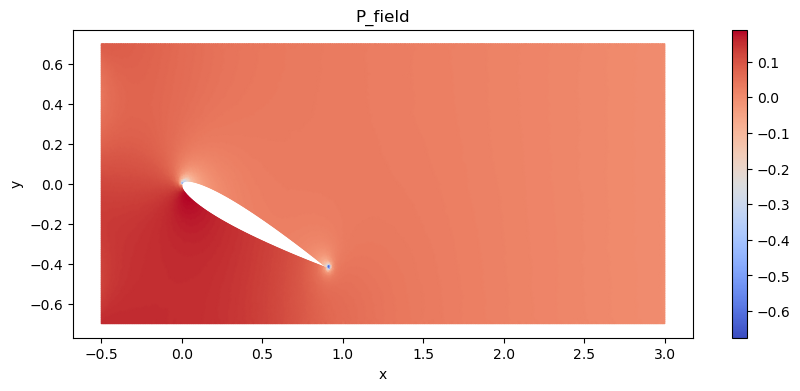

Temp num step: 0


<Figure size 640x480 with 0 Axes>

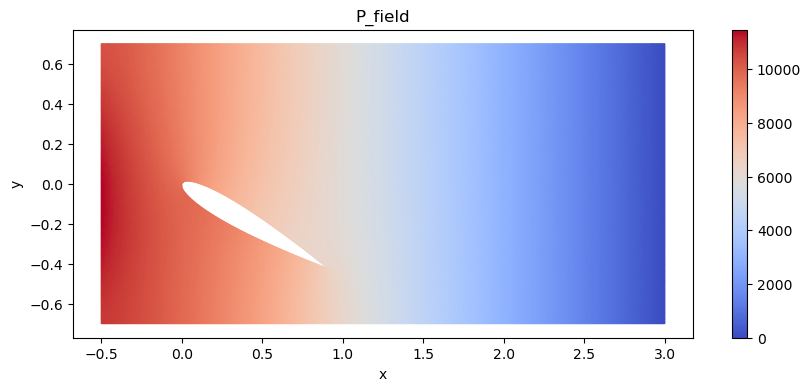

......reseted......
.....Jumping to the required time.....: 0.0 0.0


/home/kaiyuli/anaconda3/envs/fenics1/lib/python3.8/site-packages/stable_baselines3/common/env_checker.py:441: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


<Figure size 640x480 with 0 Axes>

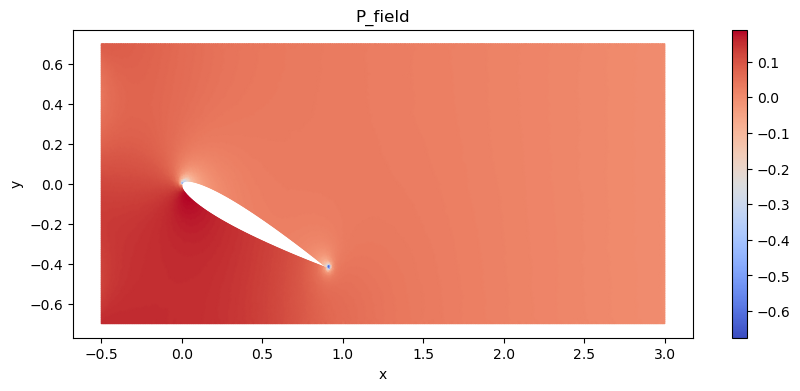

Temp num step: 0


<Figure size 640x480 with 0 Axes>

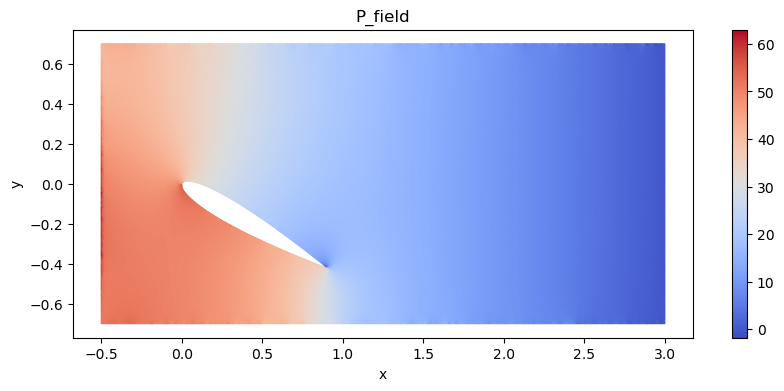

......reseted......
.....Jumping to the required time.....: 0.0 0.0


<Figure size 640x480 with 0 Axes>

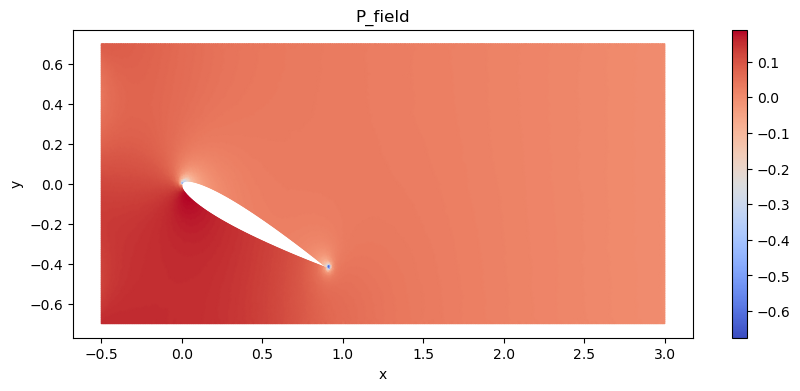

Temp num step: 0


<Figure size 640x480 with 0 Axes>

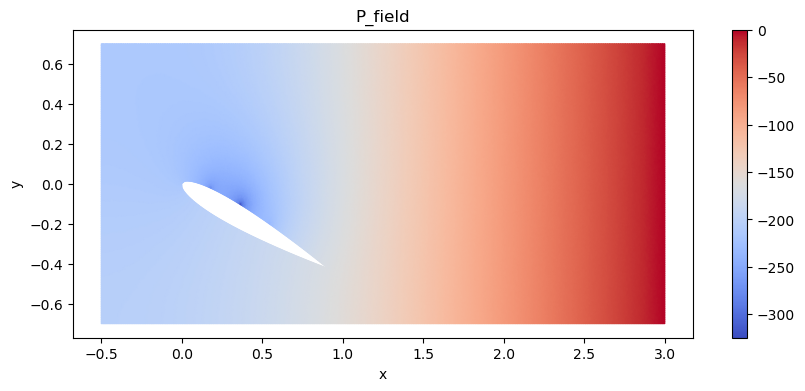

......reseted......
Temp num step: 200
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/kaiyuli/anaconda3/envs/fenics1/lib/python3.8/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2000`, after every 31 untruncated mini-batches, there will be a truncated mini-batch of size 16
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2000 and n_envs=1)
  warnings.warn(


ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=576, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=576, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=3, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)


In [4]:
ppo = PPO_model()
ppo.show_net()
ppo.train(epoch=10)
ppo.evaluate_model()
ppo.save_model()

In [ ]:
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
import torch

class RecurrentPPO_model():
    def __init__(self,env=Env2DAirfoil(),file_name="rppo_Airfoil"):
        self.env = env
        check_env(self.env)
        self.model = RecurrentPPO("MlpLstmPolicy",env,n_steps=2000,learning_rate=0.0005,verbose=1)
        self.file_name = file_name

    def train(self,total_timesteps=100000,epoch=1):
        for i in range(epoch):
            self.model.learn(total_timesteps=total_timesteps)
            self.env.reset()

    def show_net(self):
        policy_net = self.model.policy
        print(policy_net)

    def save_model(self):
        self.model.save(self.file_name)

    def load_model(self):
        del self.model
        self.model = PPO.load(self.file_name)

    def evaluate_model(self):
        mean_reward, std_reward = evaluate_policy(self.model,self.env,n_eval_episodes=5)
        print("Mean Reward:",mean_reward)
        pritn("Standard Deviation of Reward:",std_reward)

In [ ]:
rppo = RecurrentPPO_model()
rppo.show_net()
rppo.train(epoch=10)
rppo.evaluate_model()
rppo.save_model()